In [5]:
import numpy as np
import cudaq
from cudaq import spin
from typing import List
import matplotlib.pyplot as plt

cudaq.set_target("nvidia")

In [6]:
# We'll use the graph below to illustrate how QAOA can be used to
# solve a max cut problem

#       v1  0--------------0 v2
#           |              | \
#           |              |  \
#           |              |   \
#           |              |    \
#       v0  0--------------0 v3-- 0 v4
# The max cut solutions are 01011, 10100, 01010, 10101 .

# First we define the graph nodes (i.e., vertices) and edges as lists of integers so that they can be broadcast into
# a cudaq.kernel.
nodes: List[int] = [0, 1, 2, 3, 4]
edges = [[0, 1], [1, 2], [2, 3], [3, 0], [2, 4], [3, 4]]
edges_src: List[int] = [edges[i][0] for i in range(len(edges))]
edges_tgt: List[int] = [edges[i][1] for i in range(len(edges))]

In [33]:
# Problem parameters
# The number of qubits we'll need is the same as the number of vertices in our graph
qubit_count: int = len(nodes)

# We can set the layer count to be any positive integer.  Larger values will create deeper circuits
layer_count: int = 7

# Each layer of the QAOA kernel contains 2 parameters
parameter_count: int = 2 * layer_count


@cudaq.kernel
def qaoaProblem(qubit_0: cudaq.qubit, qubit_1: cudaq.qubit, alpha: float):
    """Build the QAOA gate sequence between two qubits that represent an edge of the graph
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit representing the first vertex of an edge
    qubit_1: cudaq.qubit
        Qubit representing the second vertex of an edge
    thetas: List[float]
        Free variable

    Returns
    -------
    cudaq.Kernel
        Subcircuit of the problem kernel for Max-Cut of the graph with a given edge
    """
    x.ctrl(qubit_0, qubit_1)
    rz(2.0 * alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)


# We now define the kernel_qaoa function which will be the QAOA circuit for our graph
# Since the QAOA circuit for max cut depends on the structure of the graph,
# we'll feed in global concrete variable values into the kernel_qaoa function for the qubit_count, layer_count, edges_src, edges_tgt.
# The types for these variables are restricted to Quake Values (e.g. qubit, int, List[int], ...)
# The thetas plaeholder will be our free parameters
@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, edges_src: List[int],
                edges_tgt: List[int], thetas: List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized

    Returns
    -------
    cudaq.Kernel
        QAOA circuit for Max-Cut for max cut of the graph with given edges and nodes
    """
    # Let's allocate the qubits
    qreg = cudaq.qvector(qubit_count)
    # And then place the qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add the mixer kernel to each layer
        for j in range(qubit_count):
            rx(2.0 * thetas[i + layer_count], qreg[j])

In [34]:
# The problem Hamiltonian
# Define a function to generate the Hamiltonian for a max cut problem using the graph
# with the given edges


def hamiltonian_max_cut(edges_src, edges_tgt):
    """Hamiltonian for finding the max cut for the graph with given edges and nodes

    Parameters
    ----------
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph with given edges
    """

    hamiltonian = 0

    for edge in range(len(edges_src)):

        qubitu = edges_src[edge]
        qubitv = edges_tgt[edge]
        # Add a term to the Hamiltonian for the edge (u,v)
        hamiltonian += 0.5 * (spin.z(qubitu) * spin.z(qubitv) -
                              spin.i(qubitu) * spin.i(qubitv))

    return hamiltonian

In [35]:
# Specify the optimizer and its initial parameters.
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.NelderMead()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064, 0.37118004688049144, -0.03656087558321203, 0.08564174998504231, 0.21639801853794682, 0.11122286088634259, 0.1743727097033635, -0.36518146001762486, -0.15829741539542244, -0.3467434780387345, 0.28043500852894776]


In [36]:
cudaq.set_target('nvidia')
# cudaq.set_target('qpp-cpu')

# Generate the Hamiltonian for our graph
hamiltonian = hamiltonian_max_cut(edges_src, edges_tgt)
print(edges)
print(type(hamiltonian))
print(hamiltonian)

# Define the objective, return `<state(params) | H | state(params)>`
# Note that in the `observe` call we list the kernel, the hamiltonian, and then the concrete global variable values of our kernel
# followed by the parameters to be optimized.


def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         edges_src, edges_tgt, parameters).expectation()


# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

# Alternatively we can use the vqe call (just comment out the above code and uncomment the code below)
# optimal_expectation, optimal_parameters = cudaq.vqe(
#    kernel=kernel_qaoa,
#    spin_operator=hamiltonian,
#    argument_mapper=lambda parameter_vector: (qubit_count, layer_count, edges_src, edges_tgt, parameter_vector),
#    optimizer=optimizer,
#    parameter_count=parameter_count)

print('optimal_expectation =', optimal_expectation)
print('Therefore, the max cut value is at least ', -1 * optimal_expectation)
print('optimal_parameters =', optimal_parameters)

[[0, 1], [1, 2], [2, 3], [3, 0], [2, 4], [3, 4]]
<class 'cudaq.operator.expressions.OperatorSum'>
[0.5+0j] IIZIZ
[0.5+0j] IZZII
[-3+0j] IIIII
[0.5+0j] ZZIII
[0.5+0j] IIIZZ
[0.5+0j] IIZZI
[0.5+0j] ZIIZI

optimal_expectation = -4.841262724658009
Therefore, the max cut value is at least  4.841262724658009
optimal_parameters = [0.44204719810976356, -0.09856634060171598, 0.5582875203918349, 0.9053995256169856, 0.6851623616511653, 0.15663931832716554, 0.02830749678077949, 0.6056838830272067, 0.7592566915028671, 0.04583036967340811, 0.11031582068806059, -0.387799444030262, -0.6706430651434818, 1.3474084775698825]


In [39]:
result = cudaq.sample(kernel_qaoa, qubit_count, layer_count, edges_src, edges_tgt, optimal_parameters, shots_count=1000000)
print(result)
result_list = []
for i in result:
    result_list.append((i, result[i]))
# print(result_dict)
result_list = sorted(result_list, key=lambda x: x[0])
print(result_list)

{ 00000:567 00001:910 00010:1341 00011:581 00100:1450 00101:629 00110:40882 00111:446 01000:368 01001:6135 01010:217592 01011:218189 01100:2335 01101:2316 01110:6233 01111:348 10000:339 10001:6210 10010:2271 10011:2381 10100:217736 10101:217689 10110:6175 10111:335 11000:471 11001:40768 11010:568 11011:1386 11100:557 11101:1403 11110:867 11111:522 }

[('00000', 567), ('00001', 910), ('00010', 1341), ('00011', 581), ('00100', 1450), ('00101', 629), ('00110', 40882), ('00111', 446), ('01000', 368), ('01001', 6135), ('01010', 217592), ('01011', 218189), ('01100', 2335), ('01101', 2316), ('01110', 6233), ('01111', 348), ('10000', 339), ('10001', 6210), ('10010', 2271), ('10011', 2381), ('10100', 217736), ('10101', 217689), ('10110', 6175), ('10111', 335), ('11000', 471), ('11001', 40768), ('11010', 568), ('11011', 1386), ('11100', 557), ('11101', 1403), ('11110', 867), ('11111', 522)]


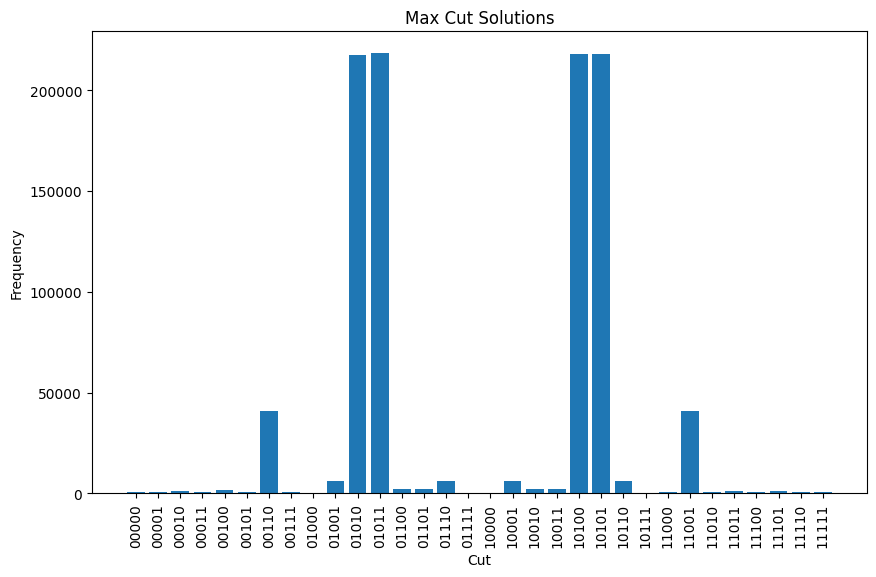

In [40]:
# plt
plt.figure(figsize=(10, 6))
plt.bar([str(i[0]) for i in result_list], [i[1] for i in result_list])
plt.xlabel('Cut')
plt.ylabel('Frequency')
plt.title('Max Cut Solutions')
plt.xticks(rotation=90)
plt.show()